# Statistics Canada Assignment: Machine Learning
# Assignment 1

In [174]:
import numpy as np
import pandas as pd
import os
from scipy.io import loadmat
import glob
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
from random import sample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from scipy.stats import entropy
from scipy.special import entr
from sklearn.calibration import CalibratedClassifierCV

# Task 1 - Build a function that converts a labelled dataset into labelled and unlabelled subsets

In [29]:
def convertLabelled(dataset_labels, proportion):
    """ converts a labelled dataset into labelled and unlabelled subsets.
        dataset_labels is an integer list containing the labels of the dataset.
        proportion is the proportion of the dataset that is desired to be unlabelled. It should be between [0,1]
        This function outputs a dataframe with the original labels and and extra column that indicates whether to keep
        or remove the label
    """
    # A random tuple of (value,index) pair from the dataset_labels
    index_value = sample(list(enumerate(dataset_labels)), round(len(dataset_labels)*proportion))
    # Creating a dataframe with the original labels and a new column labelled. Labelled has two possible values,
    # 1 indicates that the label is kept and 0 indicates that the label is removed
    df_converted_labels = pd.DataFrame(np.array([df_annotated_images_clean['class_idx'], 
                                                 np.ones(len(df_annotated_images_clean['class_idx']))]).T,
                                       columns = ['class_idx','labelled'])    
    indexes = []
    for idx, val in index_value:
        indexes.append(idx)  
    df_converted_labels.loc[indexes, 'labelled'] = 0
    return df_converted_labels, indexes

# Task 2 - Data cleaning

In [4]:
# A list to keep the removed images
removed_img_list =[]
# Images directory
img_dir = r'C:\Users\yussu\Desktop\STATCAN_EXAM\car_ims'
# iterate over images in that directory and remove images that are not RGB
for filename in os.listdir(img_dir):
    filepath = os.path.join(img_dir, filename)
    with Image.open(filepath) as im:
        if im.mode != 'RGB':
            im.close()
            # Removing non RGB images
            removed_img_list.append(filename) 
            os.remove(filepath) 

In [5]:
removed_img_list

['000050.jpg',
 '001053.jpg',
 '001225.jpg',
 '001257.jpg',
 '001265.jpg',
 '001269.jpg',
 '001270.jpg',
 '001287.jpg',
 '001301.jpg',
 '001302.jpg',
 '001310.jpg',
 '001311.jpg',
 '001312.jpg',
 '001319.jpg',
 '001327.jpg',
 '001334.jpg',
 '001366.jpg',
 '001369.jpg',
 '001390.jpg',
 '001403.jpg',
 '001412.jpg',
 '001458.jpg',
 '003338.jpg',
 '003543.jpg',
 '003712.jpg',
 '004819.jpg',
 '005031.jpg',
 '005537.jpg',
 '006398.jpg',
 '008015.jpg',
 '011672.jpg',
 '013394.jpg',
 '014690.jpg',
 '014761.jpg']

In [6]:
# Loading cars_annos.mat file
cars_annos = loadmat(r'C:\Users\yussu\Desktop\STATCAN_EXAM\cars_annos.mat')
# Creating annotations array
annotations = np.transpose(cars_annos['annotations']) 
image_annotation = []
# Extracting image name and class for each iamge from annotations array and appending image_annotation
for annotation in annotations:
    img_name = annotation[0][0][0].split('/')[1]
    class_idx= annotation[0][5][0][0]
    image_annotation.append((img_name,class_idx))
# Storing image name and class in a df_annotated_images dataframe
df_annotated_images = pd.DataFrame(image_annotation, columns = ['image_name','class_idx'])
# Removing the list of removed images during the cleaning task from df_annotated_images
df_annotated_images_clean= df_annotated_images[~df_annotated_images.image_name.isin(removed_img_list)]
df_annotated_images_clean.reset_index(inplace = True, drop=True)

# Task 3 - Dataset representation

In [7]:
# Loading the pretrained resnet18 model
model = models.resnet18(pretrained=True)
# Replacing the final layer in the resnet18 model with an identity layer
model.fc = nn.Identity(512)
# Setting resnet18 model to evaluation mode
model.eval()
# PyTorch transforms for resizing images
scaler = transforms.Resize ((224, 224))
# PyTorch transforms for normalizing images
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
# Creating ‘to_tensor’ transform to convert an image to a PyTorch tensor 
to_tensor = transforms.ToTensor()
def get_embedding(image_name):
        """ This function is a feature embedder. It takes an image as an input and returns its embeddings
        """
    # Loading an image
    image = Image.open(image_name)
    # Creating a PyTorch Variable with the transformed image
    transformed_image = Variable(normalize(to_tensor(scaler(image))).unsqueeze(0))
    # Initializing the embedding vector. Size should match with model.fc layer size
    my_embedding = torch.zeros(1,512)
    # Creating a function to copy the output of a layer
    def copy_data(m, i, o):
        my_embedding.copy_(o.data)
    # Attaching that function to a selected layer
    h = model.fc.register_forward_hook(copy_data)
    # Running the resnet18 model on the transformed image
    model(transformed_image)
    # Detaching our copy function from the layer
    h.remove()
    # Returning the embedding vector
    return my_embedding

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [220]:
dataset = {}
image_index=0
# Creating dataset dictionary 
for image in os.listdir(img_dir):
    filepath = os.path.join(img_dir, image)
    embedding = get_embedding(filepath)
    dataset[image_index+1] = {'embedding':embedding,'class_idx':df_annotated_images_clean.loc[image_index,'class_idx'], 'labelled':1}
    image_index+=1

In [21]:
# Saving the dataset dictionary
torch.save(dataset, r'C:\Users\yussu\Desktop\STATCAN_EXAM\model.pt')

# Task 4 - Build a partially labelled dataset

In [219]:
# Extracting the indices with no labels 
df_converted_labels, indexes = convertLabelled(df_annotated_images_clean['class_idx'], 0.4)
# Changing 'labelled' key to 0 for the given indices
for i in indexes:
    dataset[i+1]['labelled'] = 0

# Task 5 - Create train/validation split function

In [41]:
def train_val_split(dataset_inputs, dataset_labels, training_proportion):
    """ 
    This function creates a train/validation sets from a labelled data 
    """
    X_train, X_test, y_train, y_test = train_test_split(dataset_inputs, dataset_labels, test_size=1- training_proportion, random_state=42)
    return X_train, y_train, X_test, y_test

# Task 6 - Create experiments to convince clients that more labelled data will improve model performance

In [159]:
# Extracting the labelled data subset
labelled_dataset = {}
dataset_inputs = []
dataset_labels = []
for key, value in dataset.items():
    if dataset[key]['labelled'] == 1:
        labelled_dataset[key] = value
# Create lists for inputs and labels 
for key, value in labelled_dataset.items():
    dataset_inputs.append(labelled_dataset[key]['embedding'])
    dataset_labels.append(labelled_dataset[key]['class_idx'])
# Converting tensors to numpy arrays
dataset_inputs = np.array([t.numpy() for t in dataset_inputs])
# dataset inputs reshaping 
nsamples, nx, ny = dataset_inputs.shape
dataset_inputs = dataset_inputs.reshape((nsamples,nx*ny))
# Create a variable train and test split and train the model on different training proportion values
training_proportion = [0.3,0.4,0.5,0.6, 0.7, 0.75, 0.8, 0.85]
# Scaling the input and using a pipeline
clf = make_pipeline(StandardScaler(),
                     SGDClassifier(loss = 'log', max_iter=2000, tol=1e-3))
calibrated_clf = CalibratedClassifierCV(base_estimator=clf, method='sigmoid')  # set the SGD classifier as the base estimator

accuracy = []
for train_proportion in training_proportion:
    X_train, y_train, X_test, y_test = train_val_split(dataset_inputs, dataset_labels, train_proportion)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred))

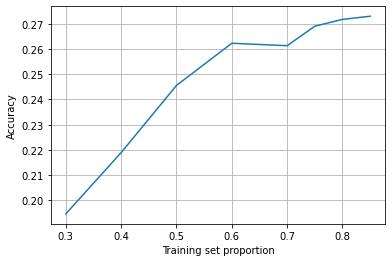

In [147]:
# Model performance assesment using accuracy as a performance metric
plt.plot(training_proportion, accuracy)
plt.xlabel('Training set proportion')
plt.ylabel('Accuracy')
plt.grid()
plt.show()



As shown from the accuracy curve above, the larger the training set, the better the accuracy. Based on the accuracy performance metric, it is clear that having more labelled data for training will likely improve the accuracy of the prediciton model.

# Task 7 - Active learning to select new instances to be labelled

In [216]:
# Extracting the Unlabelled data subset
unlabelled_dataset = {}
unlabelled_dataset_inputs = []
unlabelled_dataset_labels = []
for key, value in dataset.items():
    if dataset[key]['labelled'] == 0:
        unlabelled_dataset[key] = value
# Create lists for inputs and labels 
for key, value in unlabelled_dataset.items():
    unlabelled_dataset_inputs.append(unlabelled_dataset[key]['embedding'])
    unlabelled_dataset_labels.append(unlabelled_dataset[key]['class_idx'])
# Converting tensors to numpy arrays
unlabelled_dataset_inputs = np.array([t.numpy() for t in unlabelled_dataset_inputs])
# dataset inputs reshaping 
nsamples, nx, ny = unlabelled_dataset_inputs.shape
unlabelled_dataset_inputs = unlabelled_dataset_inputs.reshape((nsamples,nx*ny))
# predicting probability scores for each class
probabilities = clf.predict_proba(unlabelled_dataset_inputs)
np.seterr(divide='ignore', invalid='ignore')
# Calculation of entropy
Entropy = entr(probabilities).sum(axis=1)

# Calculating K instances required to be added to labelled dataset
k = round(len(df_annotated_images_clean)*0.25)
# K indicies with maximum entrpoy
indicies_max_entropy = np.argpartition(Entropy, len(Entropy) - k)[-k:]
added_dataset_inputs = unlabelled_dataset_inputs[indicies_max_entropy] 
added_dataset_labels = np.array(unlabelled_dataset_labels)[indicies_max_entropy.astype(int)]
dataset_labels = np.array(dataset_labels)
# Creating final inputs and labels
final_dataset_inputs = np.concatenate((dataset_inputs, added_dataset_inputs), axis=0)
final_dataset_labels = np.concatenate((dataset_labels, added_dataset_labels), axis=0)

# Task 8 - Final model training and evalution

In [217]:
# Scaling the input and using a pipeline
clf_extended_input = make_pipeline(StandardScaler(),
                     SGDClassifier(loss = 'hinge', max_iter=2000, tol=1e-3))
calibrated_clf_extended_input = CalibratedClassifierCV(base_estimator=clf, method='sigmoid')  # set the SGD classifier as the base estimator

accuracy_extended_input = []
for train_proportion in training_proportion:
    X_train, y_train, X_test, y_test = train_val_split(final_dataset_inputs, final_dataset_labels, train_proportion)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy_extended_input.append(accuracy_score(y_test, y_pred))


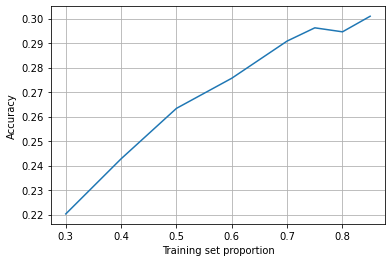

In [218]:
# Model performance assesment using accuracy as a performance metric with extended set of inputs/labels
plt.plot(training_proportion, accuracy_extended_input)
plt.xlabel('Training set proportion')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

As can be shown from the above accuracy figure, there is an improvement with the extended set of labelled data. This confirms the hypothesis that the decision for labelling more data was correct. There are few points that should be mentioned:

1) In this implementation, accuracy performance metric was used. To have more confidence in the results, other performance metrics such as the analysis of the ROC curves could be used. 

2) Feature extraction could have been improved to enhance model performance. Also no hyper-parameter optimization was done.

2) Some of the code could be more modular to avoid redundancy. If I had more time, I would create a function for training and model evaluation. 